In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/'))

In [2]:
import numpy as np

import qiskit
provider = qiskit.IBMQ.load_account()
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA
from shared.QiskitMaxcut import *
from ibm.ibm_parameters import *
from shared.gem.gem_instance import GEMInstance
from shared.gem.gem_quantum_instance import GEMQuantumInstance
from matplotlib import pyplot as plt
%matplotlib inline

graph_05_06_02_w


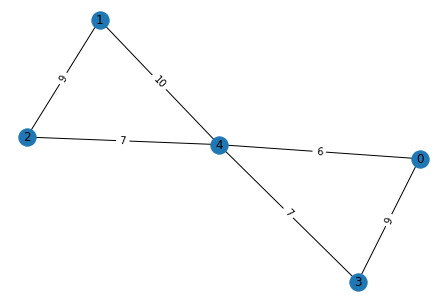

In [41]:
graph = generate_butterfly_graph(with_weights=True)
max_cut = Maxcut(graph)
max_cut_qubo = max_cut.to_qubo()
print(graph.name)
max_cut.draw()

In [62]:
step_size = 0.1
a_gamma = np.arange(0, np.pi, step_size)
b_beta = np.arange(0, np.pi, step_size)

In [63]:
a_gamma, b_beta = np.meshgrid(a_gamma, b_beta)
len(a_gamma)

32

In [64]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i,j,w in graph.edges.data('weight'):
        if x[i] != x[j]:
            obj -= w
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

In [65]:
import qiskit
from qiskit import Aer
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.models import BackendConfiguration
from helpers.config import *
import pickle 
from shared.gem.gem_quantum_instance import GEMQuantumInstance

#
# Quantum Instance 
#
DEFAULT_QASM_SIMULATOR = "qasm_simulator"
NOISE_BACKEND = "ibmq_toronto"

# Noise 
noise_model = None 
coupling_map = None
basis_gates = None

# create instance depending on config 
def create_quantum_instance():
    from helpers.config import BACKEND

    quantum_instance = None
    
    if BACKEND.value == Backend.Simulator.value:
        return GEMQuantumInstance(
                                        backend=Aer.get_backend(DEFAULT_QASM_SIMULATOR),
                                        shots=SHOTS,
                                        )
    
    if BACKEND.value == Backend.Simulator_Noise_Model.value:
        quantum_instance = _create_simulator_with_noise_quantum_instance()
        print("create noise")
    elif BACKEND.value == Backend.IBMQ_Toronto.value:
        raise Exception("Quantum Instance with Toronto not implemented!")
    else: 
        raise Exception(f"Quantum Instance not instanciated! {BACKEND.value}")
    
    return quantum_instance


def _init_noise_model_parameters():
    global noise_model, coupling_map, basis_gates
    if noise_model is None or coupling_map is None or basis_gates is None:
        noise_model_filename = f"helpers/ibmq_toronto_noise_model_dict.pkl"
        noise_model_dict = load_from_pickle(noise_model_filename)
        noise_model = NoiseModel.from_dict(noise_model_dict)
        basis_gates = noise_model.basis_gates
        
        noise_backend_configuration_filename = f"helpers/ibmq_toronto_noise_backend_configuation_dict.pkl"
        noise_backend_configuration_dict = load_from_pickle(noise_backend_configuration_filename)
        noise_backend_configuration = BackendConfiguration.from_dict(noise_backend_configuration_dict)
        coupling_map = noise_backend_configuration.coupling_map
        

def _create_simulator_with_noise_quantum_instance():
    
    _init_noise_model_parameters()
    
    quantum_instance = QuantumInstance(
                                        backend=Aer.get_backend(DEFAULT_QASM_SIMULATOR),
                                        shots=SHOTS,
                                        noise_model=noise_model,
                                        coupling_map=coupling_map,
                                        basis_gates=basis_gates,
                                        measurement_error_mitigation_cls=CompleteMeasFitter,
                                        measurement_error_mitigation_shots=SHOTS,
                                        )
    return quantum_instance


def load_from_pickle(name):
    with open(name, 'rb') as f:
        return pickle.load(f)


In [66]:
#quantum_instance = GEMQuantumInstance(
#                    #backend=Aer.get_backend(DEFAULT_QASM_SIMULATOR),
#                    backend=provider.get_backend('ibmq_sydney'),
#                    shots=SHOTS)


quantum_instance = create_quantum_instance()

qaoa = QAOA(
            optimizer=COBYLA(maxiter=0),
            quantum_instance=quantum_instance,
            reps=1
            )

op, offset = max_cut_qubo.to_ising()

create noise


In [67]:
def create_cirucit(gamma,beta):
    circuits = qaoa.construct_circuit([gamma,beta], operator=op)
    circuit = circuits[0]
    circuit.measure_all()
    return circuit

In [68]:
#gem_instance = GEMInstance()

In [69]:
first_circuit = create_cirucit(0.5,0.5)
first_circuit.draw()

┌───┐     ┌───┐┌──────────────────────┐     ┌───┐┌───┐»
   q_0: ┤ H ├─────┤ X ├┤ Rz(4.50000000000000) ├─────┤ X ├┤ X ├»
        ├───┤┌───┐└─┬─┘├──────────────────────┤┌───┐└─┬─┘└─┬─┘»
   q_1: ┤ H ├┤ X ├──┼──┤ Rz(4.50000000000000) ├┤ X ├──┼────┼──»
        ├───┤└─┬─┘  │  └──────────────────────┘└─┬─┘  │    │  »
   q_2: ┤ H ├──■────┼────────────────────────────■────┼────┼──»
        ├───┤       │                                 │    │  »
   q_3: ┤ H ├───────■─────────────────────────────────■────┼──»
        ├───┤                                              │  »
   q_4: ┤ H ├──────────────────────────────────────────────■──»
        └───┘                                                 »
meas: 5/══════════════════════════════════════════════════════»
                                                              »
«        ┌──────────────────────┐┌───┐┌──────────────────────┐»
«   q_0: ┤ Rz(3.00000000000000) ├┤ X ├┤ Rx(1.00000000000000) ├»
«        └──────────────────────┘└─┬─┘└────────┬───┬─────────┘»
«   q_1: ──────────────────────────┼───────────┤ X ├──────────»
«                                  │           └─┬─┘          »
«   q_2: ──────────────────────────┼─────────────┼────────────»
«                                  │             │            »
«   q_3: ──────────────────────────┼─────────────┼────────────»
«                                  │             │            »
«   q_4: ──────────────────────────■─────────────■────────────»
«                                                             »
«meas: 5/═════════════════════════════════════════════════════»
«                                                             »
«                                                             »
«   q_0: ─────────────────────────────────────────────────────»
«        ┌──────────────────────┐┌───┐┌──────────────────────┐»
«   q_1: ┤ Rz(5.00000000000000) ├┤ X ├┤ Rx(1.00000000000000) ├»
«        └──────────────────────┘└─┬─┘└────────┬───┬─────────┘»
«   q_2: ──────────────────────────┼───────────┤ X ├──────────»
«                                  │           └─┬─┘          »
«   q_3: ──────────────────────────┼─────────────┼────────────»
«                                  │             │            »
«   q_4: ──────────────────────────■─────────────■────────────»
«                                                             »
«meas: 5/═════════════════════════════════════════════════════»
«                                                             »
«                                                             »
«   q_0: ─────────────────────────────────────────────────────»
«                                                             »
«   q_1: ─────────────────────────────────────────────────────»
«        ┌──────────────────────┐┌───┐┌──────────────────────┐»
«   q_2: ┤ Rz(3.50000000000000) ├┤ X ├┤ Rx(1.00000000000000) ├»
«        └──────────────────────┘└─┬─┘└────────┬───┬─────────┘»
«   q_3: ──────────────────────────┼───────────┤ X ├──────────»
«                                  │           └─┬─┘          »
«   q_4: ──────────────────────────■─────────────■────────────»
«                                                             »
«meas: 5/═════════════════════════════════════════════════════»
«                                                             »
«                                                              ░ ┌─┐         »
«   q_0: ──────────────────────────────────────────────────────░─┤M├─────────»
«                                                              ░ └╥┘┌─┐      »
«   q_1: ──────────────────────────────────────────────────────░──╫─┤M├──────»
«                                                              ░  ║ └╥┘┌─┐   »
«   q_2: ──────────────────────────────────────────────────────░──╫──╫─┤M├───»
«        ┌──────────────────────┐┌───┐┌──────────────────────┐ ░  ║  ║ └╥┘┌─┐»
«   q_3: ┤ Rz(3.50000000000000) ├┤ X ├┤ Rx(1.00000000000000) ├─░──╫──╫──╫─┤M├»
«        └──────────────────────┘└─┬─┘├─────────

In [70]:
#mg = gem_instance.get_gem_matrix(first_circuit, quantum_instance)

In [71]:
#quantum_instance.MG = mg
#mg

In [72]:
landscape = np.zeros(a_gamma.shape)

for i in range(0, len(landscape)):
    circuits = []
    for j in range(0, len(landscape)):
        # create circuits for entire row 
        circuit = create_cirucit(a_gamma[i][j], b_beta[i][j])
        circuits.append(circuit)
        
    
    # create one job with circuits 
    job_name = f"{graph.name}_gem_row_{i}"
    job = quantum_instance.execute(circuits)
    #job.update_name(job_name)
    print(job_name)
    #print(job)
    
    # add results to landscape 
    k = 0
    for count in job.get_counts():
        mean = compute_expectation(count, graph)
        landscape[i,k % 32] = mean
        k += 1


graph_05_06_02_w_gem_row_0
graph_05_06_02_w_gem_row_1
graph_05_06_02_w_gem_row_2
graph_05_06_02_w_gem_row_3
graph_05_06_02_w_gem_row_4
graph_05_06_02_w_gem_row_5
graph_05_06_02_w_gem_row_6
graph_05_06_02_w_gem_row_7
graph_05_06_02_w_gem_row_8
graph_05_06_02_w_gem_row_9
graph_05_06_02_w_gem_row_10
graph_05_06_02_w_gem_row_11
graph_05_06_02_w_gem_row_12
graph_05_06_02_w_gem_row_13
graph_05_06_02_w_gem_row_14
graph_05_06_02_w_gem_row_15
graph_05_06_02_w_gem_row_16
graph_05_06_02_w_gem_row_17
graph_05_06_02_w_gem_row_18
graph_05_06_02_w_gem_row_19
graph_05_06_02_w_gem_row_20
graph_05_06_02_w_gem_row_21
graph_05_06_02_w_gem_row_22
graph_05_06_02_w_gem_row_23
graph_05_06_02_w_gem_row_24
graph_05_06_02_w_gem_row_25
graph_05_06_02_w_gem_row_26
graph_05_06_02_w_gem_row_27
graph_05_06_02_w_gem_row_28
graph_05_06_02_w_gem_row_29
graph_05_06_02_w_gem_row_30
graph_05_06_02_w_gem_row_31


[[-23.74414062 -23.75097656 -23.91894531 ... -24.18554688 -24.01074219
  -23.88476562]
 [-24.01612786 -22.48083678 -23.77800549 ... -24.78540526 -23.29354716
  -24.09013468]
 [-24.01337728 -19.61391886 -22.70777524 ... -24.5516965  -24.32980365
  -24.11153738]
 ...
 [-23.55500835 -26.27919912 -23.08495165 ... -23.89439975 -25.10690766
  -23.68246813]
 [-23.98901538 -26.3639009  -23.4289634  ... -23.7640173  -25.20603332
  -23.77352485]
 [-23.93808213 -24.46441301 -23.79380736 ... -23.75561637 -24.05855433
  -23.75489757]]


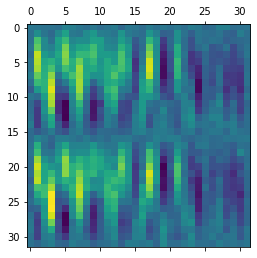

In [73]:
print(landscape)
plt.matshow(landscape)
plt.show()

In [74]:
# Mean of landscape
np.mean(landscape)

-23.531126274425013

In [75]:
# Minimium 
np.min(landscape)

-28.810848773299867

In [76]:
# Display Coordinates of Minimum 
np.unravel_index(np.argmin(landscape), landscape.shape)

(11, 5)

In [77]:
# Gamma and beta value of Minimium
gamma, beta = np.unravel_index(np.argmin(landscape), landscape.shape)
opt_gamma = gamma * step_size
opt_beta = beta * step_size
print(f"Opt.Gamma: {opt_gamma}, Opt.Beta: {opt_beta}")

Opt.Gamma: 1.1, Opt.Beta: 0.5


In [78]:
# Save result matrix 
with open('landscape_toronto_noise_model_butterfly_weights_em_results.npy', 'wb') as f:
    np.save(f, landscape)

In [79]:
import plotly.graph_objects as go

In [80]:
# Plot landscape in 3D 
a_gamma = np.arange(0, np.pi, step_size)
b_beta = np.arange(0, np.pi, step_size)
fig = go.Figure(data=go.Surface(z=landscape, x=a_gamma, y=b_beta))

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor='limegreen', project_z=True))


fig.update_layout(title="QAOA with General Error Mitigation - MaxCut-Landscape", scene=dict(
    xaxis_title="γ",
    yaxis_title="β",
    zaxis_title="F(γ,β)"
))

In [81]:
# Plot Heatmap 
fig = go.Figure(data=go.Heatmap(z=landscape, x=b_beta, y=a_gamma, type = 'heatmap', colorscale = 'viridis'))

# Update Layout
fig.update_layout(title="F(γ,β)", width=700, height=700, yaxis_title="β", xaxis_title="γ")

# Display Global Minimium 
fig.add_trace(
    go.Scatter(mode="markers", x=[opt_beta], y=[opt_gamma], marker_symbol=[204], text = [landscape[gamma,beta]],
                   marker_color="red",  hovertemplate="x: %{x}<br>y: %{y}<br> z: %{text:.2f}<extra></extra>", 
                   marker_line_width=1, marker_size=16))

In [82]:
# Display Optimizer Results

# Display path 
#fig.add_trace(
#    go.Scatter(mode="lines", x=gammas, y=betas, marker_symbol=[200],
#                   marker_color="white", marker_line_width=1, marker_size=8)
#)

# Display start point
#fig.add_trace(
#    go.Scatter(mode="markers", x=[gammas[0]], y=[betas[0]], marker_symbol=[204],
#                   marker_color="gray", 
#                   marker_line_width=1, marker_size=16))

# Display end point
#fig.add_trace(
#    go.Scatter(mode="markers", x=[gammas[-1]], y=[betas[-1]], marker_symbol=[204],
#                   marker_color="green", 
#                   marker_line_width=1, marker_size=16))



In [25]:
# Plot Optimizer History
#fig = go.Figure(data=go.Scatter(x=counts, y=values))
#fig.update_layout(xaxis_title="Evaluation Counts", yaxis_title="Evaluated Mean", title="Optimizer")
#fig.show()